# Homework 6- Francesco Ortu

The UCI ML hand-written digits datasets contains 8x8 images of digits belonging to 10 different classes:

In [140]:
import sklearn
import pyro
import pyro.optim as optim
import pyro.distributions as dist
import torch.distributions.constraints as constraints
import numpy as np
import torch
import matplotlib.pyplot as plt

In [141]:

from sklearn.datasets import load_digits
dataset = load_digits()

x, y = dataset.data, dataset.target
print("predictors shape =", x.shape)
print("labels shape =", y.shape)
print("n. unique labels =", len(np.unique(y)))

predictors shape = (1797, 64)
labels shape = (1797,)
n. unique labels = 10


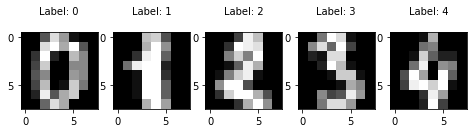

In [142]:
plt.figure(figsize=(8,3))
for index, (image, label) in enumerate(zip(x[0:5], y[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Label: %i\n' % label, fontsize = 10)

## 1
 Normalize the matrix of predictors and perform a train/test split using `train_test_split` from `sklearn` library.

In [143]:
#Normalize the data
for i in range(0,x.shape[0]):
    x[i] = x[i] / (x[i].max()-x[i].min())



In [144]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = torch.tensor(x_train, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

## 2/3
Use pyro to write a multinomial bayesian logistic regression model $^1$. You should define both a `guide()` function and a `model()` function. Use a Categorical distributions on the outcomes to solve this multiclass classification problem.
Run SVI inference using pyro `Adam` optimizer and plot the ELBO loss using `matplotlib.plot` function.

In [145]:
pyro.clear_param_store()
def logistic_regression_model(x,y):
    n_obs, n_predictors = x.shape
    w = pyro.sample('w', dist.Normal(torch.zeros(n_predictors,10), torch.ones(n_predictors,10)).independent(2))
    b = pyro.sample('b', dist.Normal(torch.zeros(10), torch.ones(10)).independent(1))
    y_hat= torch.sigmoid(torch.matmul(x, w) + b)

    with pyro.plate('data', n_obs):
        y = pyro.sample('obs', dist.Categorical(y_hat), obs=y)

def logistic_regression_guide(x, y=None):
    n_observations, n_predictors = x.shape
    
    w_loc = pyro.param("w_loc", torch.rand(n_predictors,10))
    w_scale = pyro.param("w_scale", torch.rand(n_predictors,10), constraint=constraints.positive)
    w = pyro.sample("w", dist.Normal(w_loc, w_scale).independent(2))
    
    b_loc = pyro.param("b_loc", torch.rand(10))
    b_scale = pyro.param("b_scale", torch.rand(10), constraint=constraints.positive)
    b = pyro.sample("b", dist.Normal(b_loc, b_scale).independent(1))

log_reg_svi = pyro.infer.SVI(logistic_regression_model, logistic_regression_guide, optim.ClippedAdam({"lr": 0.05}), loss=pyro.infer.Trace_ELBO())

losses = []
for step in range(10000):
    loss = log_reg_svi.step(x_train, y_train)/len(x_train)
    losses.append(loss)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")
        

Step 0 : loss = 2.6706234341955217
Step 1000 : loss = 0.5828550260101828
Step 2000 : loss = 0.523132611250164
Step 3000 : loss = 0.7407385689895354
Step 4000 : loss = 0.7131650333364722
Step 5000 : loss = 0.6330982750293357
Step 6000 : loss = 0.6052404775665963
Step 7000 : loss = 0.6774518116530894
Step 8000 : loss = 0.8240348587620151
Step 9000 : loss = 0.6350338643179557


Text(0.5, 1.0, 'ELBO loss')

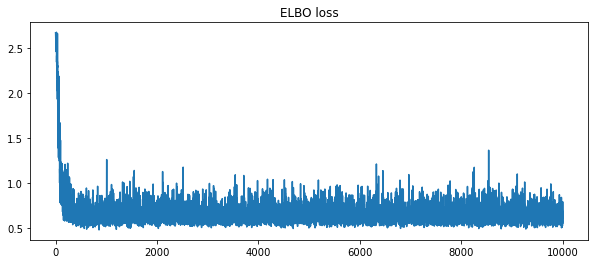

In [146]:
figsize=(10,4)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(losses)
ax.set_title("ELBO loss")

## 4 
Evaluate your model on the test data: compute the overall test accuracy and the class-wise accuracy for the 10 categories.

In [149]:
w = pyro.get_param_store()["w_loc"]
b = pyro.get_param_store()["b_loc"]
print(w.shape,b.shape)

torch.Size([64, 10]) torch.Size([10]) tensor([[0.0000, 0.0000, 0.0000,  ..., 0.8750, 0.3125, 0.0000],
        [0.0000, 0.0000, 0.6875,  ..., 0.0625, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000,  ..., 0.5000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4375,  ..., 0.6250, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4375,  ..., 1.0000, 0.2500, 0.0000],
        [0.0000, 0.0000, 0.8750,  ..., 0.3125, 0.0000, 0.0000]])


In [154]:
def predict_class(x):
    out = torch.sigmoid(torch.matmul(x, w) + b)
    return out.argmax(dim=1)

correct_predictions = (predict_class(x_test) == y_test).sum().item()

print(f"test accuracy = {correct_predictions/len(x_test)*100:.2f}%")

test accuracy = 96.11%
